In this notebook, I make plots to support the understanding of the theory section.

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

Specify settings for plots.

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 18
plt.rcParams.update({'font.size': def_font_size})

Get colors.

In [3]:
# Get color schema
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Risk Measures

## Figure 1: Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)

Suppose we have some distribution of financial returns with the following characteristics.

In [107]:
mu = 0.09
sd = 0.15
beta = 0.80

Then we can plot the distribution.

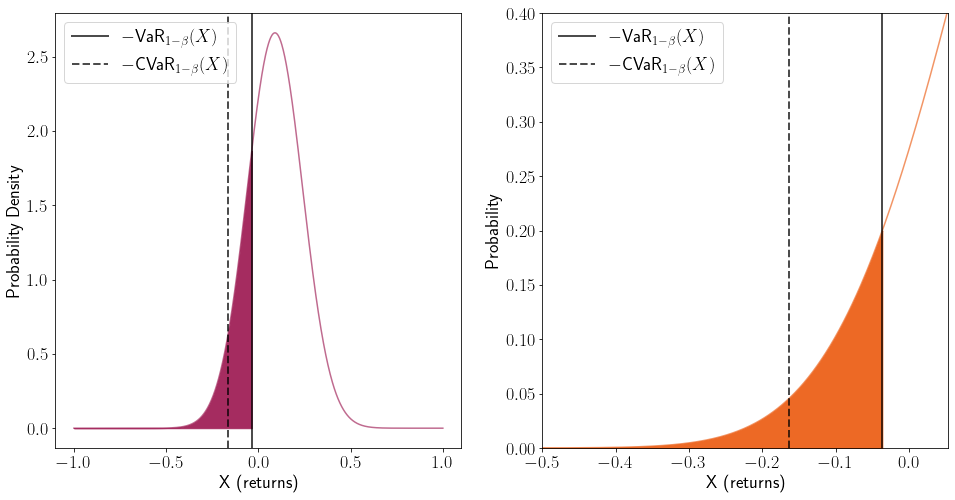

In [108]:
# Calculate x-position of VaR and CVaR
VaR = ss.norm.ppf(1-beta, loc=mu, scale=sd)
CVaR = mu - sd*(ss.norm.pdf(ss.norm.cdf(1-beta)))/(1-beta)

# Construct curve
x = np.linspace(-1, 1, 1000)
y_pdf = ss.norm.pdf(x, loc=mu, scale=sd)
y_cdf = ss.norm.cdf(x, loc=mu, scale=sd)
x_shade = np.linspace(min(x),VaR,1000)
y_shade_pdf = ss.norm.pdf(x_shade, loc=mu, scale=sd)
y_shade_cdf = ss.norm.cdf(x_shade, loc=mu, scale=sd)

# Plot left side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].plot(x, y_pdf, alpha=0.7, color=colors[4])
axs[0].axvline(VaR, alpha=0.7, color='black', label=r'$-$VaR$_{1 - \beta}(X)$', linewidth=2)
axs[0].axvline(CVaR, alpha=0.7, color='black', label=r'$-$CVaR$_{1 - \beta}(X)$', linestyle="--", linewidth=2)
axs[0].fill_between(x_shade, y_shade_pdf, color=colors[4], alpha=1)
axs[0].set_ylabel('Probability Density', fontsize=def_font_size)
axs[0].set_xlabel('X (returns)', fontsize=def_font_size)
axs[0].tick_params(axis='both', which='major', labelsize=def_font_size)
axs[0].legend(fontsize=def_font_size, loc="upper left")

# Plot right side
axs[1].plot(x, y_cdf, alpha=0.7, color=colors[6])
axs[1].axvline(VaR, alpha=0.7, color='black', label=r'$-$VaR$_{1 - \beta}(X)$', linewidth=2)
axs[1].axvline(CVaR, alpha=0.7, color='black', label=r'$-$CVaR$_{1 - \beta}(X)$', linestyle="--", linewidth=2)
axs[1].fill_between(x_shade, y_shade_cdf, color=colors[6], alpha=1)
axs[1].set_ylabel('Probability', fontsize=def_font_size)
axs[1].set_xlabel('X (returns)', fontsize=def_font_size)
axs[1].tick_params(axis='both', which='major', labelsize=def_font_size)
axs[1].set_xlim([-0.50, VaR + mu])
axs[1].set_ylim([0, 0.40])
axs[1].legend(fontsize=def_font_size, loc="upper left")

# Save figure
plt.savefig('./PlotsTheory/RiskMeasures/VarANDCVaR.pdf', dpi=150)

plt.show()

We will make one more plot where we consider two distributions with the same VaR, but different CVaR.

In [109]:
displace = 0.031174242077810173 + 0.009435122604076331
mu_low = -0.30 - displace
sd_low = 0.05

def bimodal_normal(lambda_param=0.2, mu=[mu_low, mu], sd=[sd_low, sd], size=1000):
    
    # Validate input
    if not (0 <= lambda_param <= 1):
        raise ValueError("lambda_param must be between 0 and 1")
    if len(mu) != 2 or len(sd) != 2:
        raise ValueError("mu and sd must have exactly two elements")

    # Generate samples from two normal distributions
    samples1 = np.random.normal(mu[0], sd[0], int(size * lambda_param))
    samples2 = np.random.normal(mu[1], sd[1], int(size * (1 - lambda_param)))

    # Combine the samples
    combined_samples = np.concatenate([samples1, samples2])

    return combined_samples

def quantile_function(probabilities, kde_cdf, x_range):
    return np.interp(probabilities, kde_cdf, x_range)

In [110]:
# Sample
samples = bimodal_normal(lambda_param=0.1, mu=[mu_low, mu-displace+0.10], sd=[sd_low, sd], size=100000)

# Compute KDE for bimodal distribution
kde = ss.gaussian_kde(samples)
kde_x = np.linspace(min(samples), max(samples), 10000)
kde_y = kde(kde_x)

# Numerical integration to get CDF
kde_cdf = np.cumsum(kde_y)
kde_cdf *= (kde_x[1] - kde_x[0])  # Adjust for the step size
kde_cdf /= kde_cdf[-1] # Normalize the CDF to go from 0 to 1

Then we can make the plot.

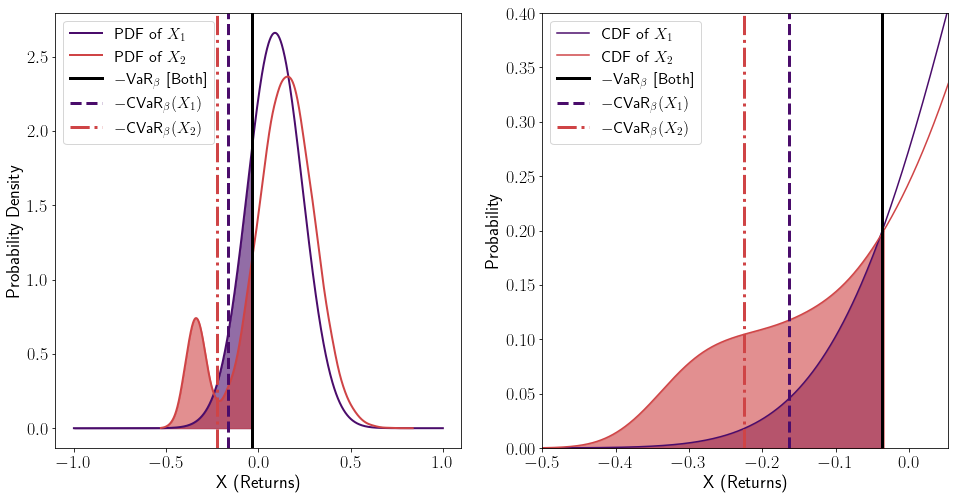

In [111]:
# Calculate x-position of VaR and CVaR
VaR = ss.norm.ppf(1-beta, loc=mu, scale=sd)
CVaR = mu - sd*(ss.norm.pdf(ss.norm.cdf(1-beta)))/(1-beta)
VaR2 = quantile_function(1-beta, kde_cdf, kde_x)
CVaR2 = np.mean(samples[samples < VaR2])

# Construct curve
x = np.linspace(-1, 1, 1000)
y_pdf = ss.norm.pdf(x, loc=mu, scale=sd)
y_cdf = ss.norm.cdf(x, loc=mu, scale=sd)
x_shade = np.linspace(min(x),VaR,1000)
x_shade2 = kde_x[kde_x <= VaR2]
y_shade_pdf = ss.norm.pdf(x_shade, loc=mu, scale=sd)
y_shade_cdf = ss.norm.cdf(x_shade, loc=mu, scale=sd)
z_shade_pdf = kde_y[kde_x <= VaR2]
z_shade_cdf = kde_cdf[kde_x <= VaR2]

# Plot left side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].plot(x, y_pdf, alpha=1, color=colors[2], label=r'PDF of $X_{1}$', linewidth=2)
axs[0].plot(kde_x, kde_y, alpha=1, color=colors[5], label=r'PDF of $X_{2}$', linewidth=2)
axs[0].axvline(VaR, alpha=1, color='black', label=r'$-$VaR$_{\beta}$ [Both]', linewidth=3)
axs[0].axvline(CVaR, alpha=1, color=colors[2], label=r'$-$CVaR$_{\beta}(X_{1})$', linestyle="--", linewidth=3)
axs[0].axvline(CVaR2, alpha=1, color=colors[5], label=r'$-$CVaR$_{\beta}(X_{2})$', linestyle="-.", linewidth=3)
axs[0].fill_between(x_shade, y_shade_pdf, color=colors[2], alpha=0.6)
axs[0].fill_between(x_shade2, z_shade_pdf, color=colors[5], alpha=0.6)
axs[0].set_ylabel('Probability Density', fontsize=def_font_size)
axs[0].set_xlabel('X (Returns)', fontsize=def_font_size)
axs[0].tick_params(axis='both', which='major', labelsize=def_font_size)
axs[0].legend(fontsize=def_font_size-2, loc="upper left")

# Plot right side
axs[1].plot(x, y_cdf, alpha=1, color=colors[2], label=r'CDF of $X_{1}$')
axs[1].plot(kde_x, kde_cdf, alpha=1, color=colors[5], label=r'CDF of $X_{2}$')
axs[1].axvline(VaR, alpha=1, color='black', label=r'$-$VaR$_{\beta}$ [Both]', linewidth=3)
axs[1].axvline(CVaR, alpha=1, color=colors[2], label=r'$-$CVaR$_{\beta}(X_{1})$', linestyle="--", linewidth=3)
axs[1].axvline(CVaR2, alpha=1, color=colors[5], label=r'$-$CVaR$_{\beta}(X_{2})$', linestyle="-.", linewidth=3)
axs[1].fill_between(x_shade, y_shade_cdf, color=colors[2], alpha=0.6)
axs[1].fill_between(x_shade2, z_shade_cdf, color=colors[5], alpha=0.6)
axs[1].set_ylabel('Probability', fontsize=def_font_size)
axs[1].set_xlabel('X (Returns)', fontsize=def_font_size)
axs[1].tick_params(axis='both', which='major', labelsize=def_font_size)
axs[1].set_xlim([-0.50, VaR + mu])
axs[1].set_ylim([0, 0.40])
axs[1].legend(fontsize=def_font_size-2, loc="upper left")

# Save figure
plt.savefig('./PlotsTheory/RiskMeasures/VarANDCVaRTwo.pdf', dpi=150)

plt.show()